# Analysis of "Experiments on Emotional Inattention---Pilot 3"


In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import ast
import math

def load_csv_files(subfolder_name):
    notebook_path = os.path.dirname(os.path.abspath('__file__'))
    data_folder_path = os.path.join(notebook_path, 'data', subfolder_name)

    all_dataframes = []
    
    # Get a list of all files in the subfolder
    files = os.listdir(data_folder_path)

    # Loop through each file and load it as a pandas DataFrame
    for file in files:
        if file.endswith('.csv'):
            file_path = os.path.join(data_folder_path, file)
            df = pd.read_csv(file_path)
            all_dataframes.append(df)

    # Concatenate all DataFrames into one, stacking them on top of each other
    combined_df = pd.concat(all_dataframes, ignore_index=True)

    return combined_df

# Usage:
subfolder_name = '2023-09-pilot3_2sequences'
data = load_csv_files(subfolder_name)

# Remove duplicates based on all columns
data.drop_duplicates(inplace=True)
# data.drop_duplicates(inplace=True,subset=['participant.label'])


# restrict to sessions:
def restrict_to_sessions(data, session_codes):
    return data[data['session.code'].isin(session_codes)]

session_codes = []
if session_codes != []:
    data = restrict_to_sessions(data, session_codes)

data.rename(columns={'pilot3.1.player.wtp': 'wtp_MPL'},inplace=True)

data.drop(columns=['participant.feedback','pilot3.1.player.payoff'], inplace=True)

# Drop all columns that do not begin with 'participant'
# data = data.filter(regex='^participant.')

data.columns = data.columns.str.replace('participant.', '')
data.columns = data.columns.str.replace('pilot3.1.player.', '')

# List of pages to check against
pages_to_exclude = ['Welcome', 'Consent']

# Create a new column 'not_in_list' based on the condition
data['started_experiment'] = data['_current_page_name'].apply(lambda x: x not in pages_to_exclude and pd.notna(x))

# # Create a new column 'finished_experiment' based on the condition
# data['finished_experiment'] = data['_current_page_name'].apply(lambda x: x == 'Finished')


# Calculate the number of rows with 'finished_experiment' equal to True for each treatment
finished_experiment_count = data[data['finished'] == True].groupby('treatment').size()

# Calculate the number of rows with 'started_experiment' equal to True for each treatment
started_experiment_count = data[data['started_experiment'] == True].groupby('treatment').size()

# Calculate the ratio for each treatment
ratio_by_treatment = finished_experiment_count / started_experiment_count

print('Attrition by treatment: ',ratio_by_treatment)

print('Starters: ', started_experiment_count)

print('Finishers: ', finished_experiment_count)

# Filter the DataFrame to only include rows where 'finished_experiment' is True
data = data[data['finished'] == True]



# Convert the JSON strings to dictionaries
# Function to parse JSON strings while handling NaN values
def parse_dict_string(dict_string):
    # Check if the input is a string
    if not isinstance(dict_string, str):
        return np.NaN
    
    # Replace single quotes with double quotes before parsing as JSON
    corrected_dict_string = dict_string.replace("'", "\"")
    try:
        return json.loads(corrected_dict_string)
    except json.JSONDecodeError:
        return np.NaN

# Convert the JSON strings to dictionaries, handling NaN values
for column in ['times','mistakes']:
    data[column] = data[column].apply(parse_dict_string)

# Custom function to calculate the total from the 'mistakes' dictionary
def calculate_mistakes_total(mistakes_dict):
    # Check if the value is a dictionary
    if isinstance(mistakes_dict, dict):
        # Extract the values from the dictionary and sum them
        total = sum(mistakes_dict.values())
        return total
    else:
        return None

# Apply the custom function to create the new column 'mistakes_total'
data['mistakes_total'] = data['mistakes'].apply(calculate_mistakes_total)

data = pd.concat([data,
                 data['times'].apply(pd.Series)
                 ], axis=1)

# Custom converter function to convert array strings to actual arrays
def parse_array_string(array_string):
    try:
        return ast.literal_eval(array_string)
    except (SyntaxError, ValueError):
        return np.NaN
    
data['experiment_sequence'] = data['experiment_sequence'].apply(parse_array_string)

data['sequence'] = data['sequence'].apply(parse_array_string)

data['wtp_MPL'] = data['wtp_MPL'].apply(parse_array_string)

data['actual_data'] = data['actual_data'].apply(parse_array_string)

# Function to calculate maximum of first N elements in a list
def max_first_n(lst, n):
    return max(lst[:n])

# # Calculate the time difference and create a new column 'task_duration'
# data['task_duration'] = data['end_task'] - data['start_task']

# Calculate the time difference and create a new column 'task_duration'
data['study_duration'] = data['time_finished'] - data['time_started']
data['study_duration_minutes'] = data['study_duration'] / 60
data['study_duration_minutes'] = data['study_duration_minutes'].round(1)

all_questions = [
    'CQ_bonus_box',
    'CQ_bonus_initial',
    'CQ_bonus_time',
    'CQ_bonus_decide',
    'CQ_bonus_num_boxes',
    'CQ_bonus_stop',
    'CQ_bonus_complete',
    'CQ_penalty_box',
    'CQ_penalty_initial',
    'CQ_penalty_time',
    'CQ_penalty_decide',
    'CQ_penalty_num_boxes',
    'CQ_penalty_stop',
    'CQ_penalty_complete',
    'CQ_bonus_forced_difference',
    'CQ_penalty_forced_difference'
    ]

for question in all_questions:
    new_data = []
    for el in data['mistakes']:
        if question in el:
            new_data.append(el[question])
        else:
            new_data.append(np.nan)
    data[question] = new_data

# Select only the desired columns
selected_columns = ['label',  'feedback', 'feedbackDifficulty', 'feedbackUnderstanding', 'feedbackSatisfied', 'feedbackPay', 'treatment', 'payoff', 'study_duration_minutes']
selected_data = data[selected_columns]

# Create the 'output' folder if it doesn't exist
output_folder = os.path.join(os.getcwd(), 'output')
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Create the 'subfolder' inside the 'output' folder if it doesn't exist
subfolder_path = os.path.join(output_folder, subfolder_name)
if not os.path.exists(subfolder_path):
    os.makedirs(subfolder_path)

# Save the selected data to a CSV file in the 'subfolder'
file_path = os.path.join(subfolder_path, 'feedback.csv')
selected_data.to_csv(file_path, index=False)

# Select only the desired columns
selected_columns = ['label',  'confused_binary', 'confused_text']
selected_data = data[selected_columns]

# Save the selected data to a CSV file in the 'subfolder'
file_path = os.path.join(subfolder_path, 'confused.csv')
selected_data.to_csv(file_path, index=False)


# Custom function to calculate the WTP
def calculate_wtp(dictionary_list):
    d = dictionary_list[-1]


    task_keys = [float(key) for key, value in d.items() if value == 'task']
    sure_keys = [float(key) for key, value in d.items() if value == 'sure']

    
    if 'task' not in d.values():
        return min(sure_keys) - 5
    
    if 'sure' not in d.values():
        return max(task_keys) + 5
    
    lowest_sure_key = min(sure_keys)
    
    highest_task_key = max(task_keys)

    if lowest_sure_key < highest_task_key:
        return np.nan
    
    return (lowest_sure_key + highest_task_key) / 2
    
# Create a new column 'new_column' based on the custom function
data['wtp_point'] = data['wtp_MPL'].apply(calculate_wtp)
data['single_switching'] = data['wtp_point'].apply(lambda x: not pd.isna(x))


data['num_draws'] = data['actual_data'].apply(lambda x: x['num_draws'])



data['emotionsPart1'] = np.where(data['emotionsPart1_bonus'].notna(), data['emotionsPart1_bonus'], data['emotionsPart1_penalty'])





Attrition by treatment:  treatment
('tasks', 'bonus', 'low', 'original', 0)      1.0
('tasks', 'bonus', 'low', 'original', 1)      1.0
('tasks', 'bonus', 'low', 'reversed', 0)      1.0
('tasks', 'bonus', 'low', 'reversed', 1)      1.0
('tasks', 'penalty', 'low', 'original', 0)    1.0
('tasks', 'penalty', 'low', 'original', 1)    1.0
('tasks', 'penalty', 'low', 'reversed', 0)    1.0
('tasks', 'penalty', 'low', 'reversed', 1)    1.0
dtype: float64
Starters:  treatment
('tasks', 'bonus', 'low', 'original', 0)      4
('tasks', 'bonus', 'low', 'original', 1)      3
('tasks', 'bonus', 'low', 'reversed', 0)      3
('tasks', 'bonus', 'low', 'reversed', 1)      3
('tasks', 'penalty', 'low', 'original', 0)    3
('tasks', 'penalty', 'low', 'original', 1)    3
('tasks', 'penalty', 'low', 'reversed', 0)    3
('tasks', 'penalty', 'low', 'reversed', 1)    2
dtype: int64
Finishers:  treatment
('tasks', 'bonus', 'low', 'original', 0)      4
('tasks', 'bonus', 'low', 'original', 1)      3
('tasks', 'bon

In [2]:


def get_element_at_index(row):
    achieved_max_bonus = True
    if row['num_draws']>0:
        sequence = json.loads(row['sequence'][row['valence']])[:int(row['num_draws'])]
        if float(max(sequence)) == float(row['actual_data']['tentative_bonus']):
            achieved_max_bonus = True
        else:
            achieved_max_bonus = False
    return achieved_max_bonus
# Create a new column 'new_column' based on the custom function
data['max_bonus_possible'] = data.apply(get_element_at_index, axis=1)


def get_sequence(row):
    
   return json.loads(row['sequence'][row['valence']])[:int(row['num_draws'])]
# Create a new column 'new_column' based on the custom function
data['actual_sequence'] = data.apply(get_sequence, axis=1)

def get_max_element_so_far(row):
    
    max_so_far = 2
    max_values = []
    for num in row['actual_sequence']:
        max_so_far = max(max_so_far, float(num))  # Update the maximum so far
        max_values.append(max_so_far) 

    max_values = max_values[:int(row['num_draws'])]
    return max_values


    
#    return json.loads(row['sequence'][row['valence']])[:int(row['num_draws'])]
# Create a new column 'new_column' based on the custom function
data['max_element_so_far'] = data.apply(get_max_element_so_far, axis=1)


def list_of_optimal_choice(row):
    optimal_choice = []
    
    sequence = json.loads(row['sequence'][row['valence']])

    tentative_bonus_sequence = row['actual_data']['tentative_bonus_sequence']

    if len(tentative_bonus_sequence)==0:
        return optimal_choice
    
    for i in range(len(tentative_bonus_sequence)):
        if i==0:
            if float(sequence[i]) > float(tentative_bonus_sequence[i]):
                optimal_choice.append(False)
            else:
                optimal_choice.append(True)

        else:
            if float(sequence[i]) > float(tentative_bonus_sequence[i]) or (float(tentative_bonus_sequence[i-1])>float(tentative_bonus_sequence[i])):
                optimal_choice.append(False)
            else:
                optimal_choice.append(True)


    return optimal_choice
# Create a new column 'new_column' based on the custom function
data['optimal_choice'] = data.apply(list_of_optimal_choice, axis=1)

data['optimal_choice']


data['share_optimal_choice'] = data['optimal_choice'].apply(lambda x: sum(x)/len(x))

# Custom function to check if all Booleans in a list are True
def check_all_true(bool_list):
    return all(bool_list)

# Create a new column 'new_column' based on the custom function
data['optimal_choice_everywhere'] = data['optimal_choice'].apply(check_all_true)

data[['actual_sequence','max_element_so_far']]



,actual_sequence,max_element_so_far
0,"[3.63, 2.51, 2.14, 2.24, 2.19, 2.89, 3.13, 2.2...","[3.63, 3.63, 3.63, 3.63, 3.63, 3.63, 3.63, 3.6..."
1,"[4.57, 2.67, 2.34, 2.04, 2.85, 2.27, 3.17, 2.3...","[4.57, 4.57, 4.57, 4.57, 4.57, 4.57, 4.57, 4.5..."
2,"[3.63, 2.51, 2.14, 2.24, 2.19, 2.89, 3.13, 2.2...","[3.63, 3.63, 3.63, 3.63, 3.63, 3.63, 3.63, 3.6..."
3,"[4.57, 2.67, 2.34, 2.04, 2.85, 2.27, 3.17, 2.3...","[4.57, 4.57, 4.57, 4.57, 4.57, 4.57, 4.57, 4.5..."
4,"[3.63, 2.51, 2.14, 2.24, 2.19, 2.89, 3.13, 2.2...","[3.63, 3.63, 3.63, 3.63, 3.63, 3.63, 3.63, 3.6..."
5,"[4.57, 2.67, 2.34, 2.04, 2.85, 2.27, 3.17, 2.3...","[4.57, 4.57, 4.57, 4.57, 4.57, 4.57, 4.57, 4.5..."
6,"[3.63, 2.51, 2.14, 2.24, 2.19, 2.89, 3.13, 2.2...","[3.63, 3.63, 3.63, 3.63, 3.63, 3.63, 3.63, 3.6..."
7,"[4.57, 2.67, 2.34, 2.04, 2.85, 2.27, 3.17, 2.3...","[4.57, 4.57, 4.57, 4.57, 4.57, 4.57, 4.57, 4.5..."
8,"[3.63, 2.51, 2.14, 2.24, 2.19, 2.89, 3.13, 2.2...","[3.63, 3.63, 3.63, 3.63, 3.63, 3.63, 3.63, 3.6..."
9,"[4.57, 2.67, 2.34, 2.04, 2.85]","[4.57, 4.57, 4.57, 4.57, 4.57]"


In [17]:
# Step 1: Create a list of strings in the required format
rows_as_text = [f"{label},{round(bonus_payment, 2)}" for label, bonus_payment in zip(data['label'], data['bonus_payment'])]

# Save the selected data to a CSV file in the 'subfolder'
file_path = os.path.join(subfolder_path, 'bonus_payment.txt')



# Step 2: Write the strings to a text file
with open(file_path, 'w') as file:
    file.write("\n".join(rows_as_text))



file_path = os.path.join(subfolder_path, 'approved.txt')



# Step 1: Create a list of strings in the required format
rows_as_text = [f"{label}" for label in data['label']]

# Step 2: Write the strings to a text file
with open(file_path, 'w') as file:
    file.write("\n".join(rows_as_text))


data['bonus_payment']






0      1.75
1      1.98
2      2.88
3      3.07
4      2.13
5      1.62
6      2.88
7      3.07
8      0.50
9      3.07
10     4.20
11     3.07
12     0.50
13     3.07
14     2.88
16    -2.00
17     3.07
18     2.13
19     1.96
20     2.88
21     1.98
22     4.20
23    12.57
24     2.88
Name: bonus_payment, dtype: float64

In [4]:


data[['emotionsPart1','emotionsPart1_bonus','emotionsPart1_penalty']]   

,emotionsPart1,emotionsPart1_bonus,emotionsPart1_penalty
0,5.0,5.0,NaN
1,9.0,9.0,NaN
2,6.0,6.0,NaN
3,6.0,6.0,NaN
4,5.0,NaN,5.0
5,1.0,NaN,1.0
6,4.0,NaN,4.0
7,9.0,NaN,9.0
8,6.0,6.0,NaN
9,4.0,4.0,NaN


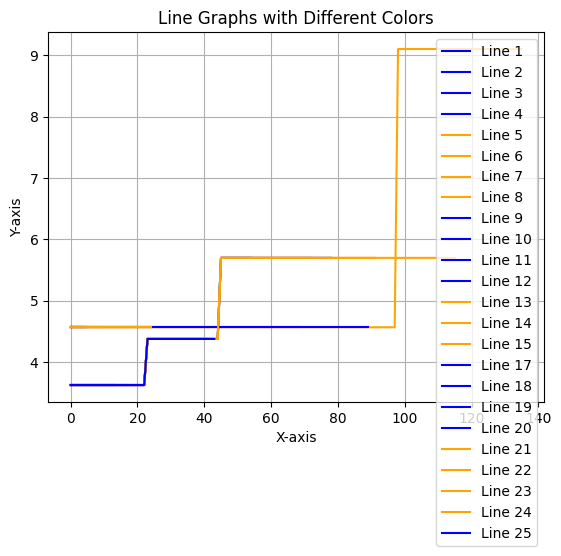

In [5]:
def plot_and_save_line_graphs(data, column_name_values, column_name_colors, subfolder_name):
    # Create a figure and axis
    fig, ax = plt.subplots()

    colors_dict = {
        'bonus': 'blue',
        'penalty': 'orange'
    }
    # Iterate through rows of the DataFrame
    for index, row in data.iterrows():
        values = row[column_name_values]
        colors = row[column_name_colors]

        # Create x values based on the length of the list
        x = np.arange(len(values))

        
        # Plot the line graph with the specified color
        ax.plot(x, values, label=f'Line {index + 1}', color=colors_dict[colors])

    # Set labels and legend
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_title('Line Graphs with Different Colors')
    ax.legend()

    # Show the plot
    ax.grid(True)

    # Create the Data directory if it doesn't exist
    if not os.path.exists('Output'):
        os.mkdir('Output')

    # Create the subfolder if it doesn't exist
    subfolder_path = os.path.join('Output', subfolder_name)
    if not os.path.exists(subfolder_path):
        os.mkdir(subfolder_path)

    # Save the figure in the subfolder
    file_path = os.path.join(subfolder_path, f'line_graphs_{subfolder_name}.png')
    plt.savefig(file_path)

    # Display the plot (optional)
    plt.show()

# Usage:
column_name_values = 'max_element_so_far'
column_name_colors = 'valence'

plot_and_save_line_graphs(data, column_name_values, column_name_colors, subfolder_name)


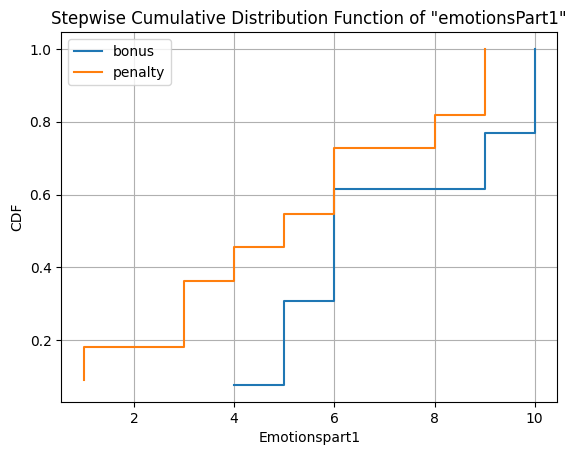

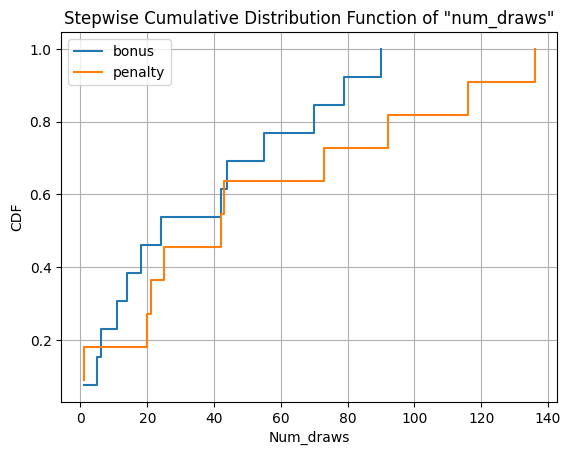

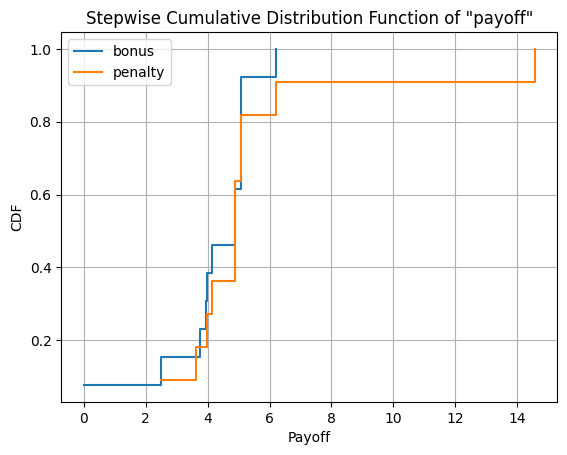

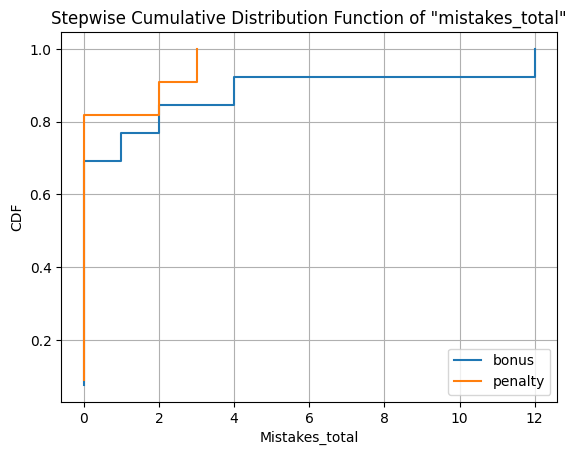

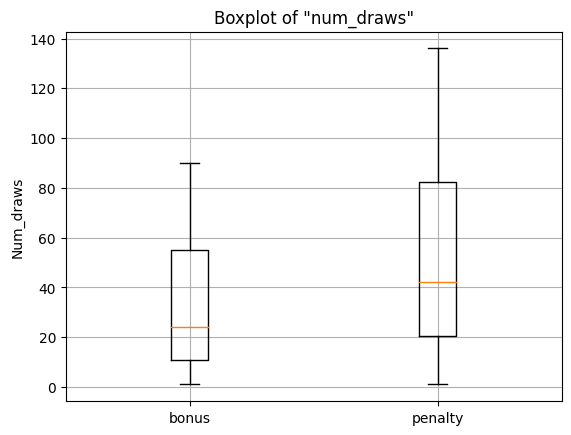

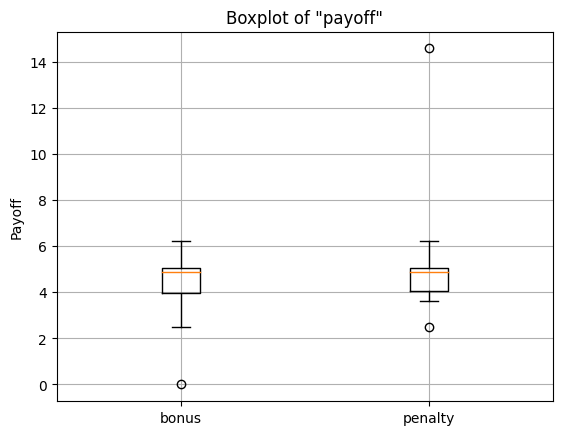

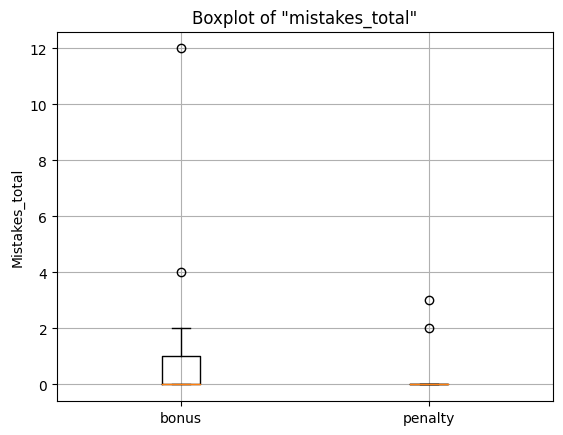

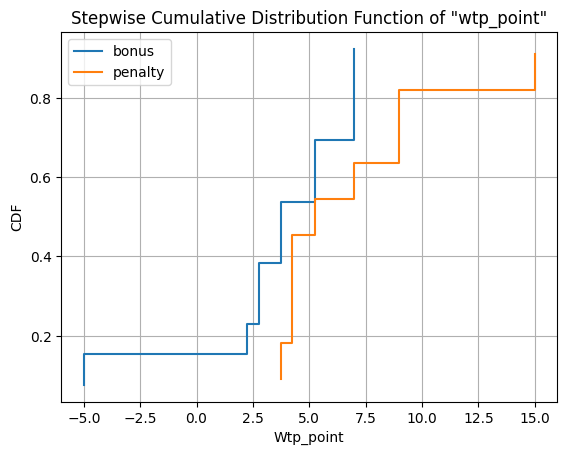

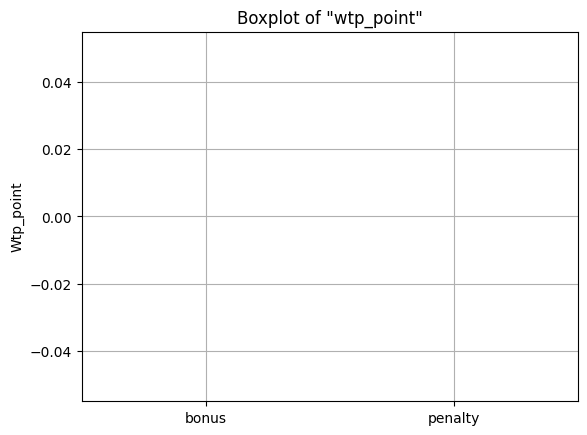

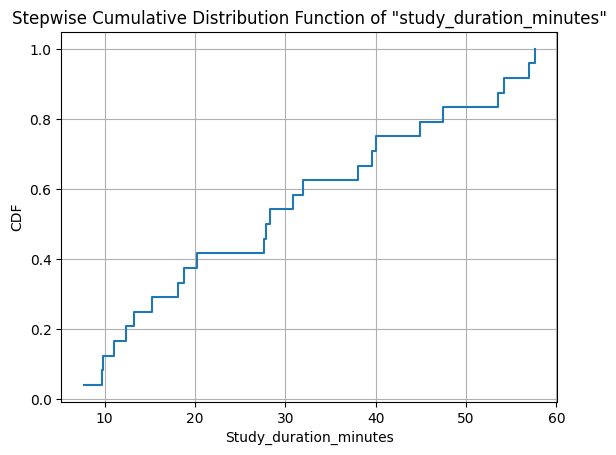

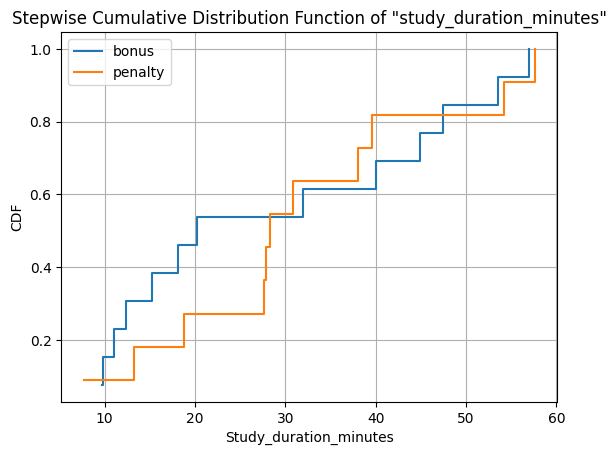

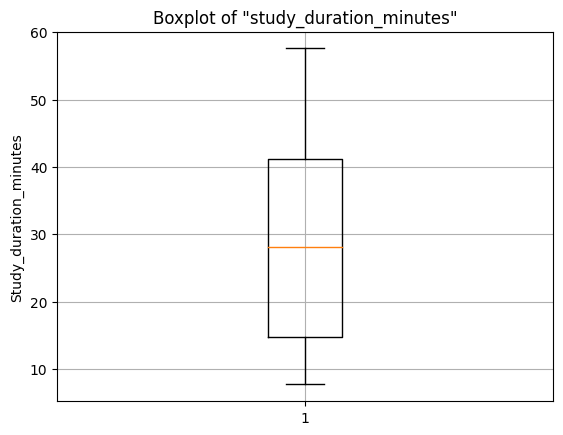

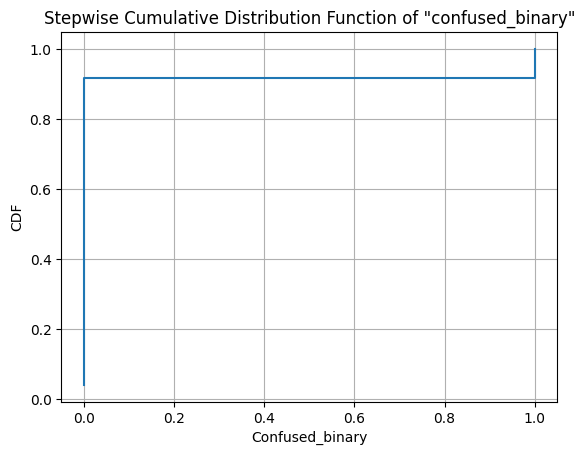

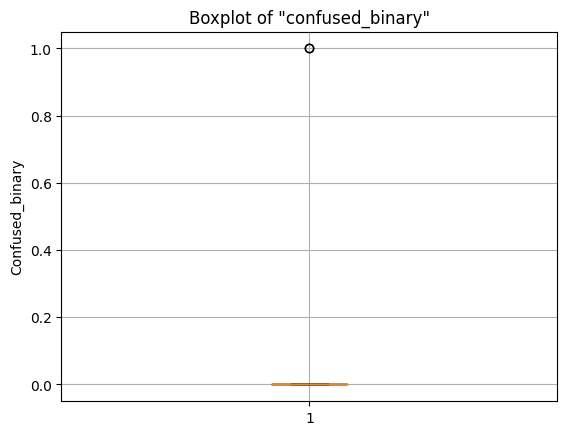

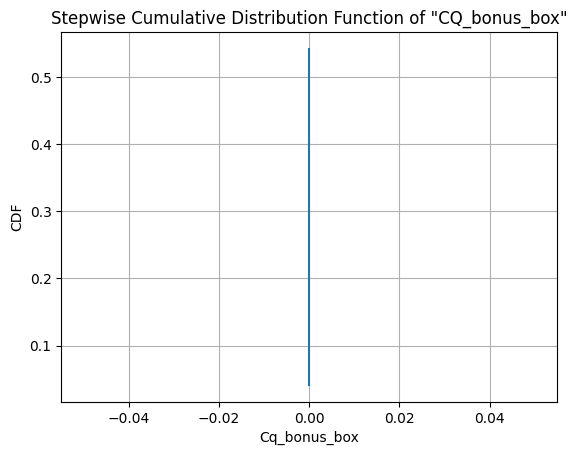

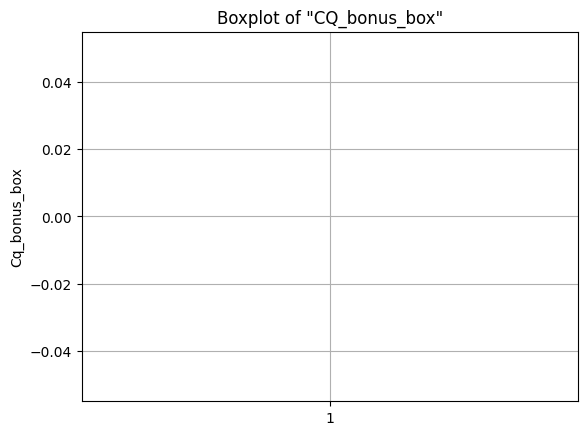

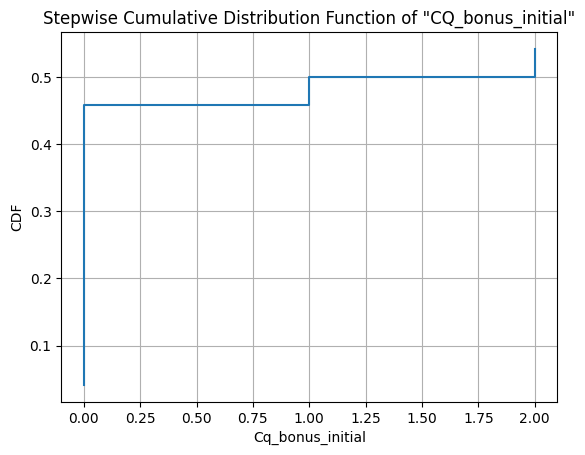

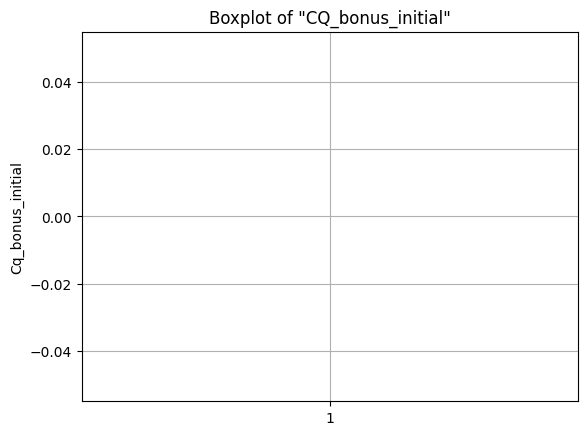

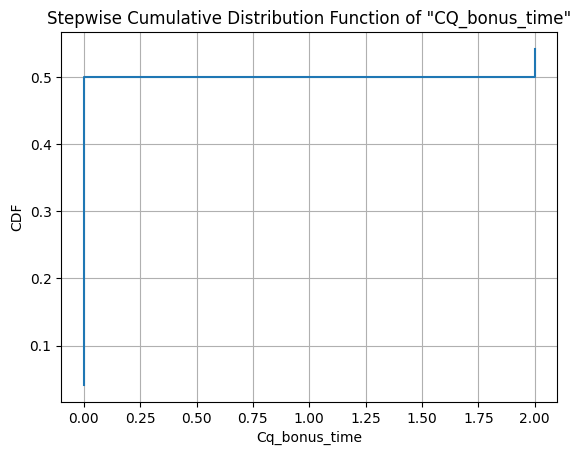

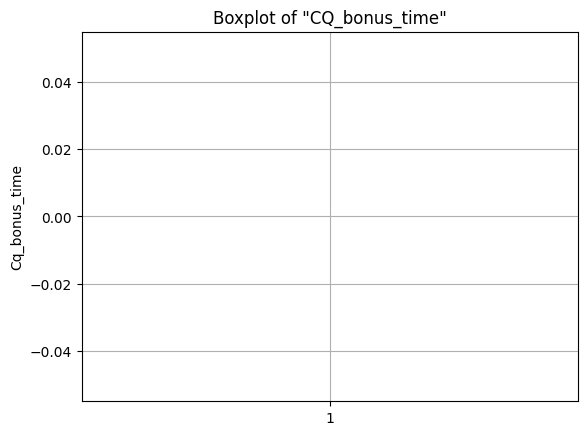

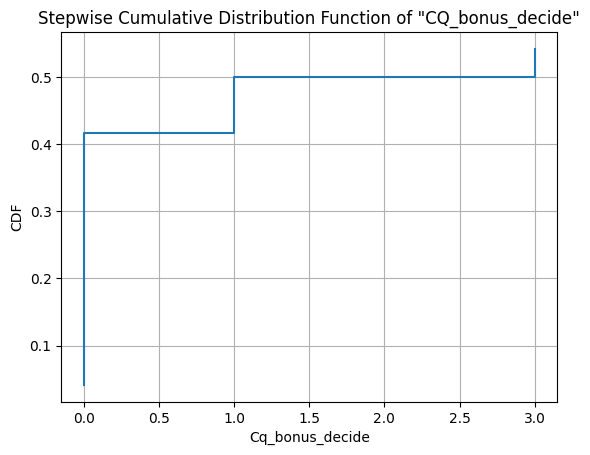

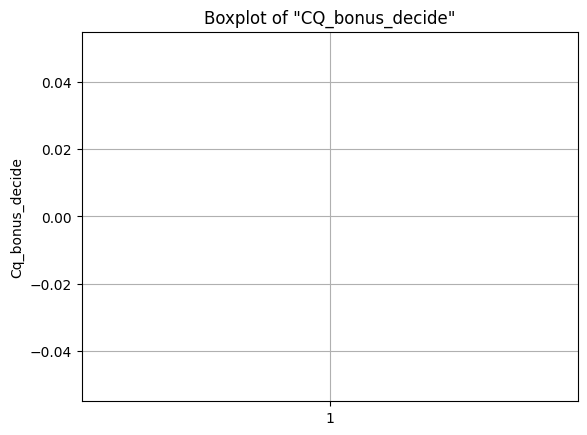

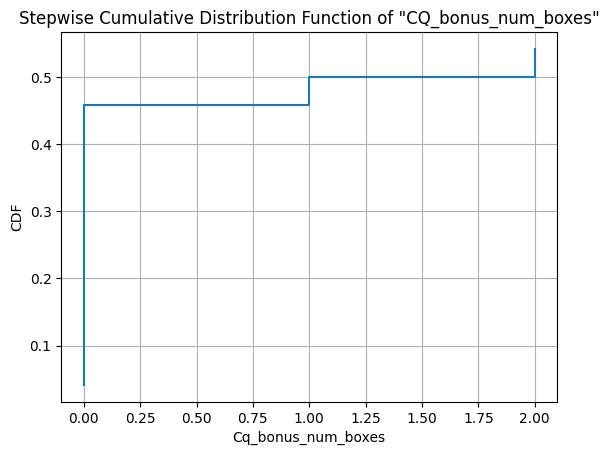

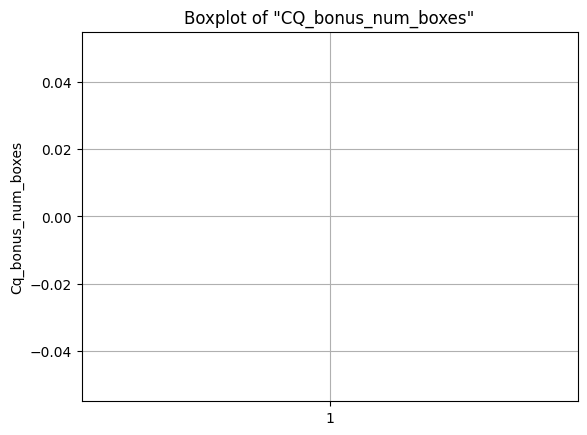

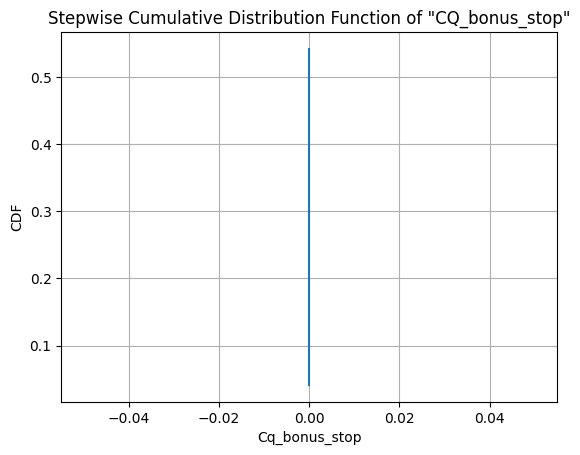

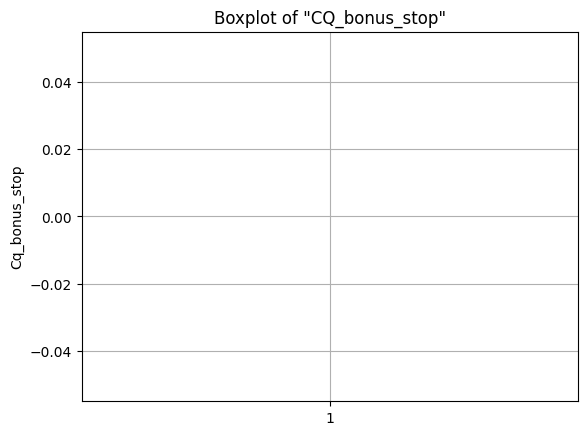

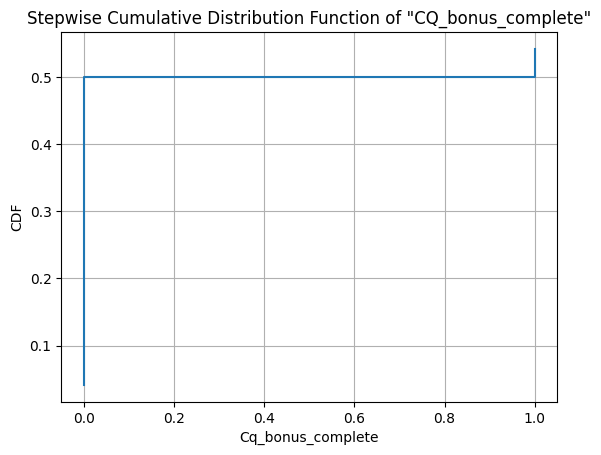

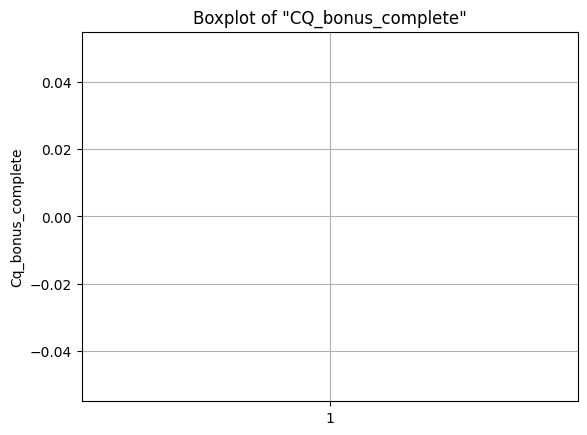

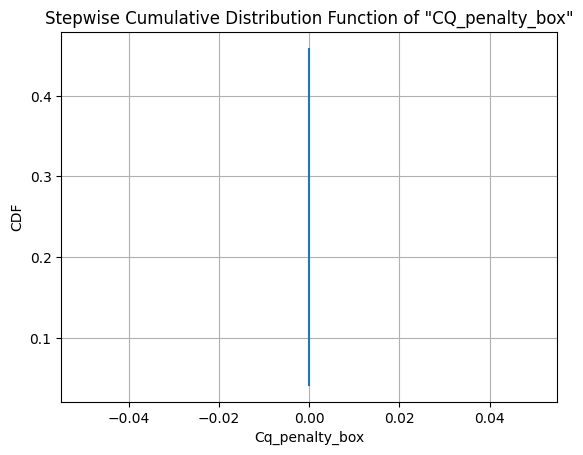

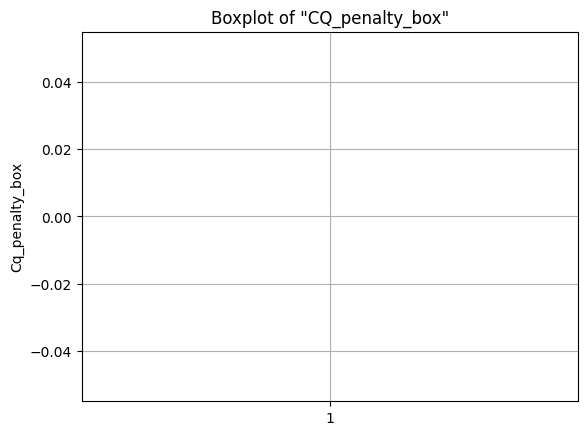

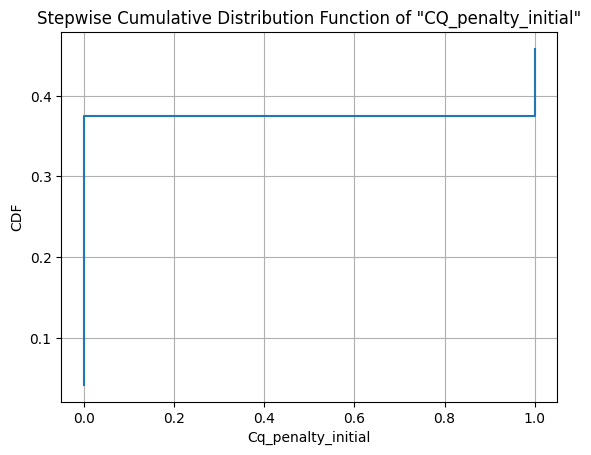

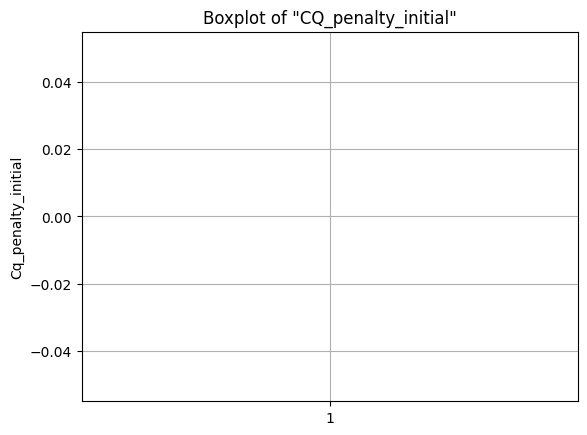

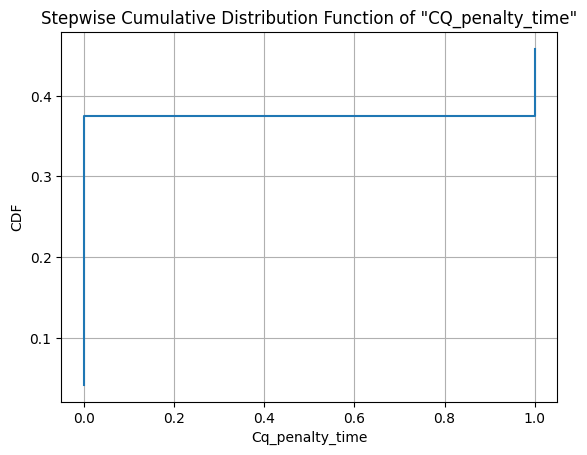

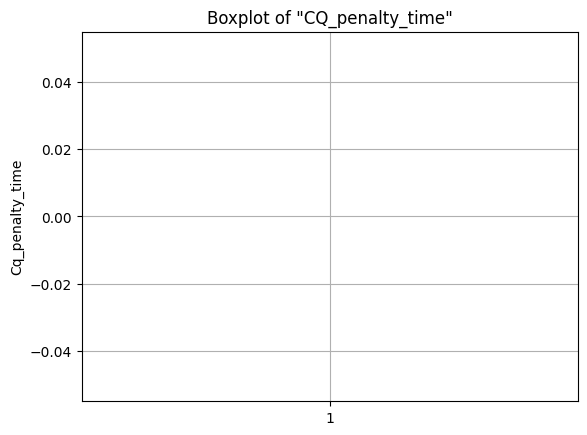

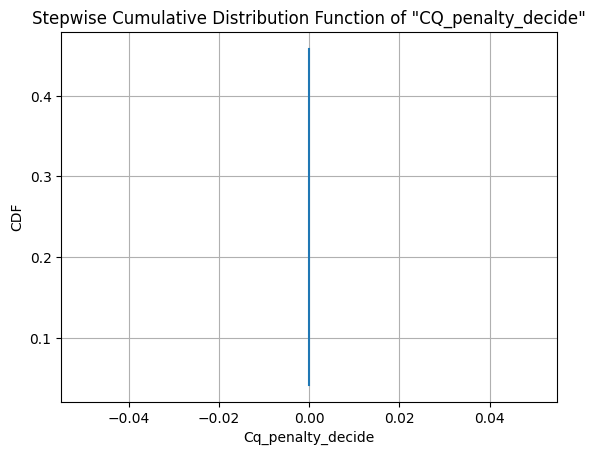

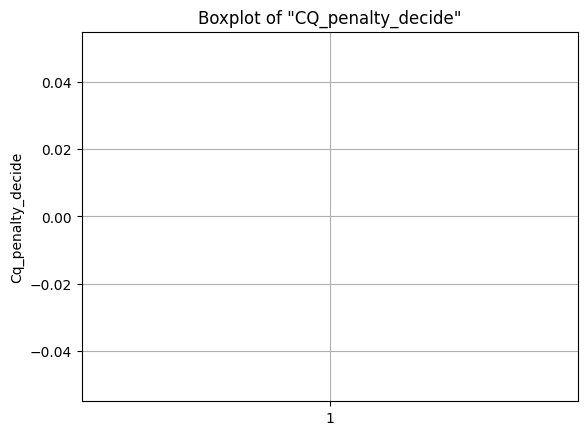

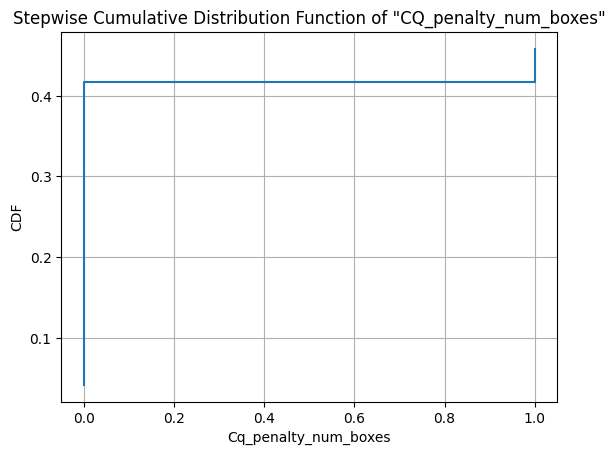

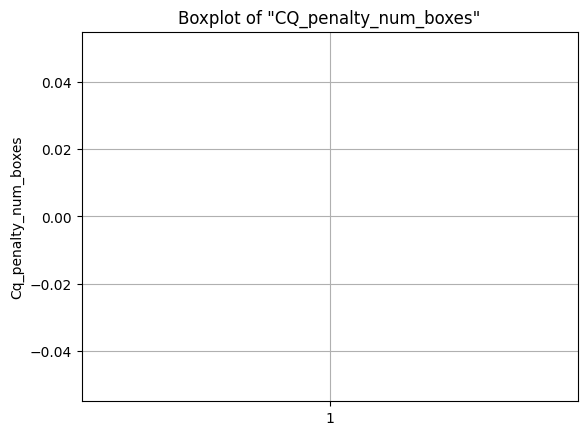

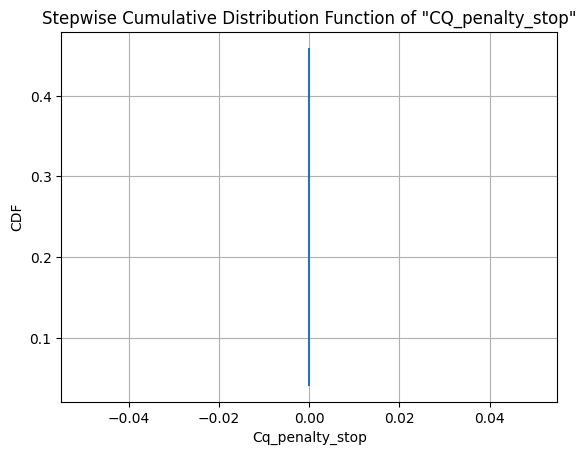

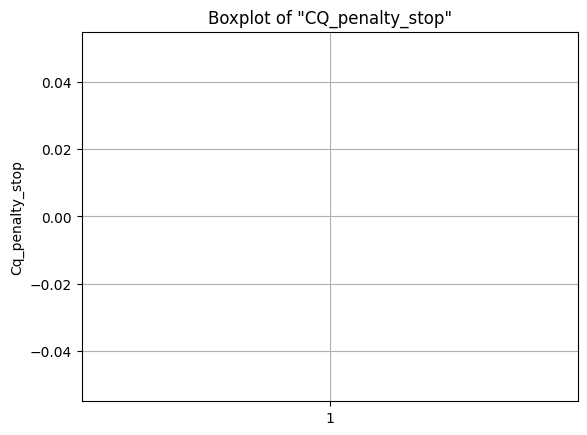

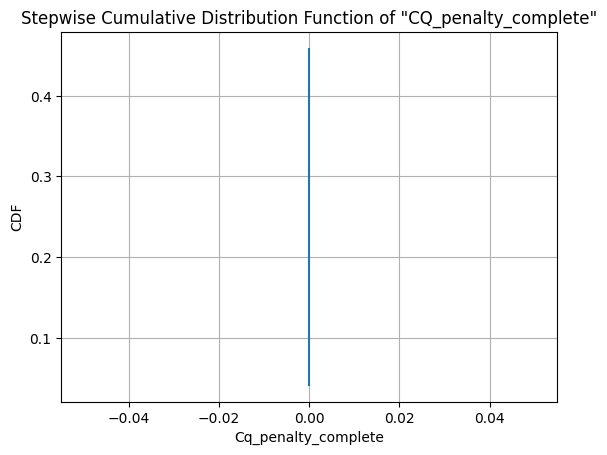

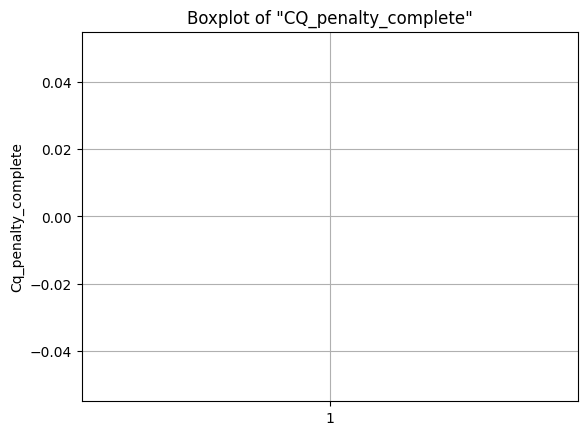

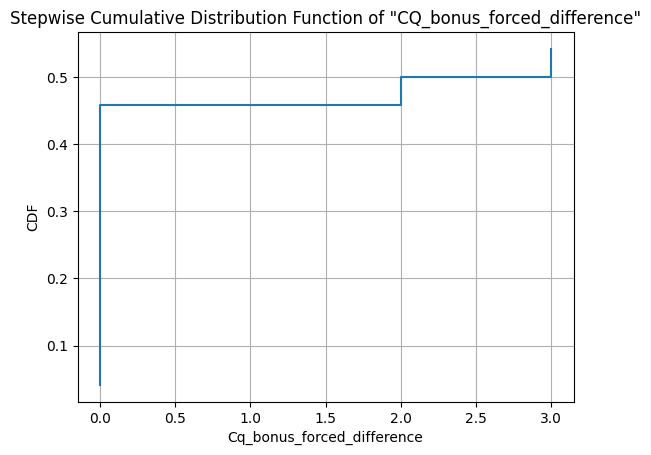

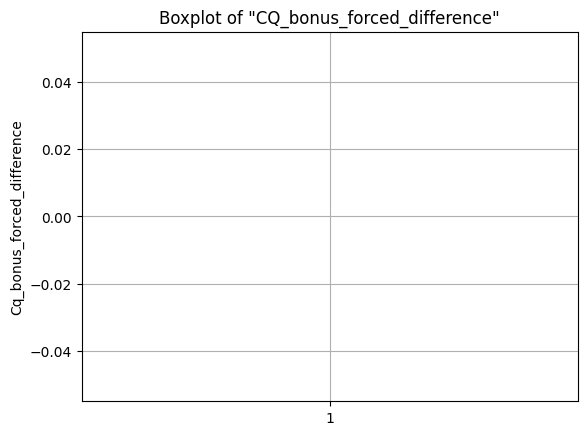

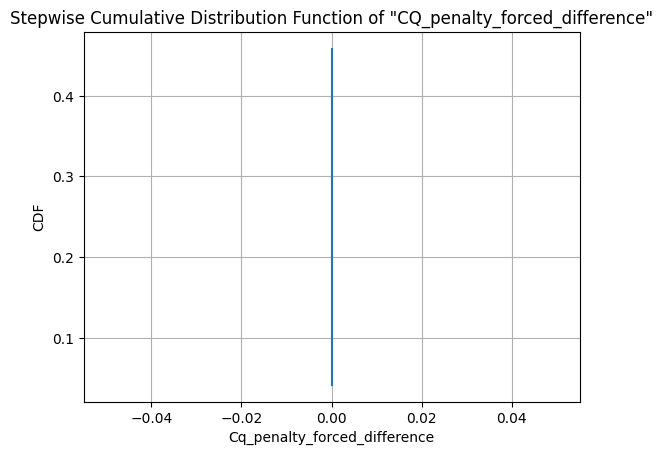

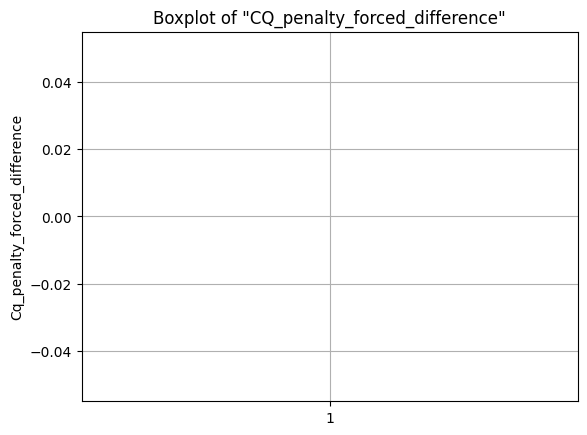

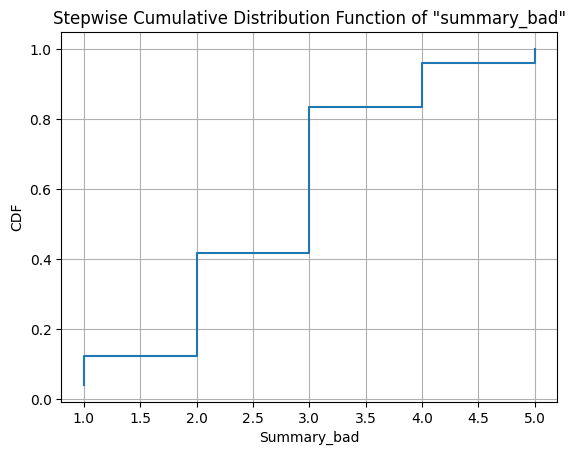

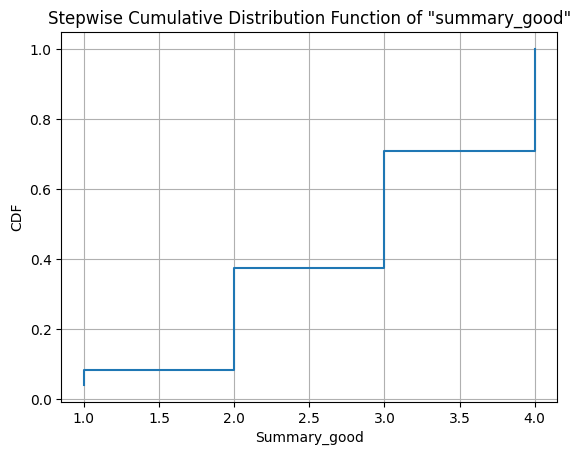

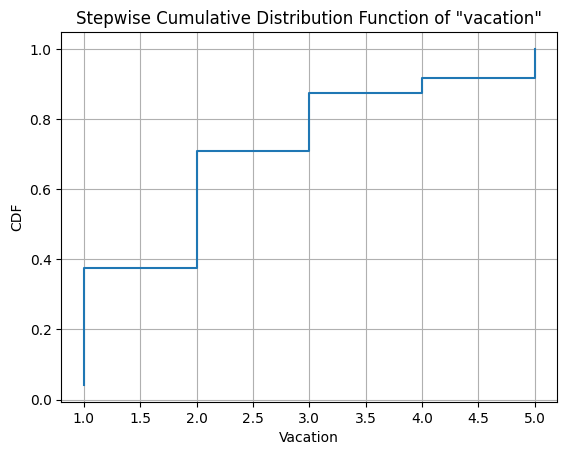

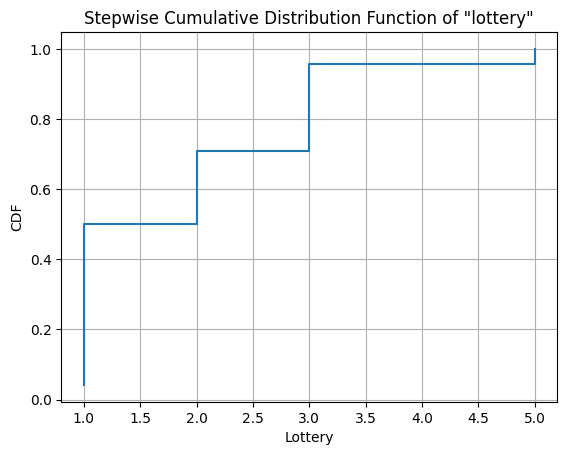

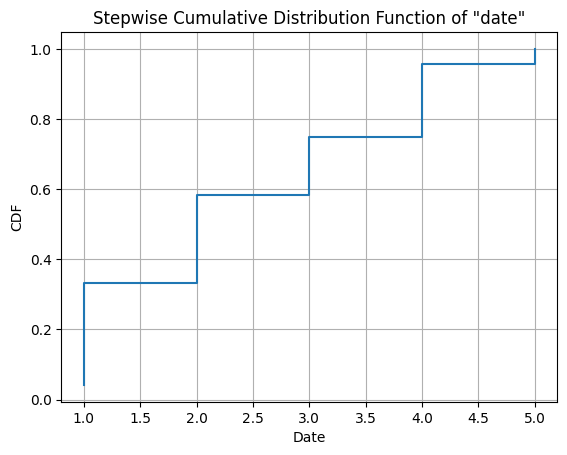

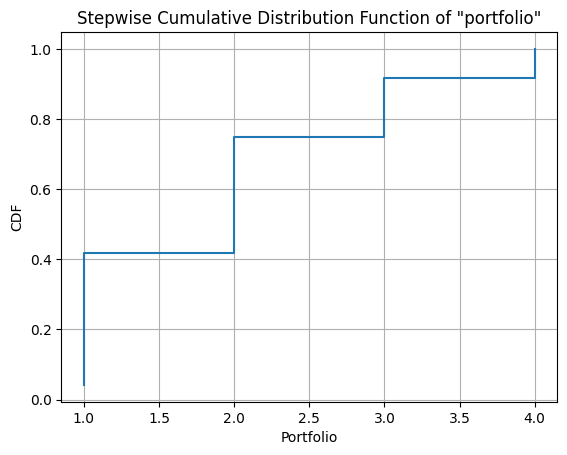

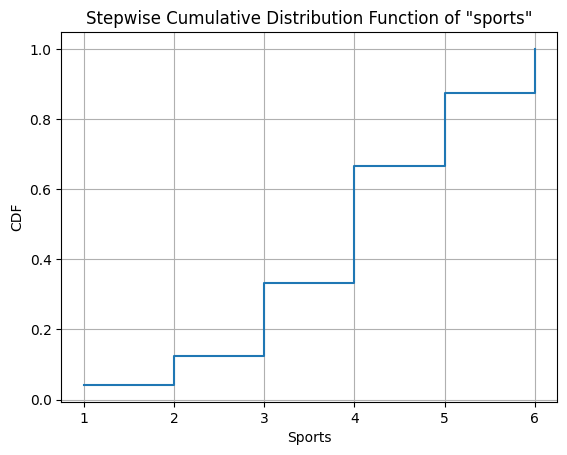

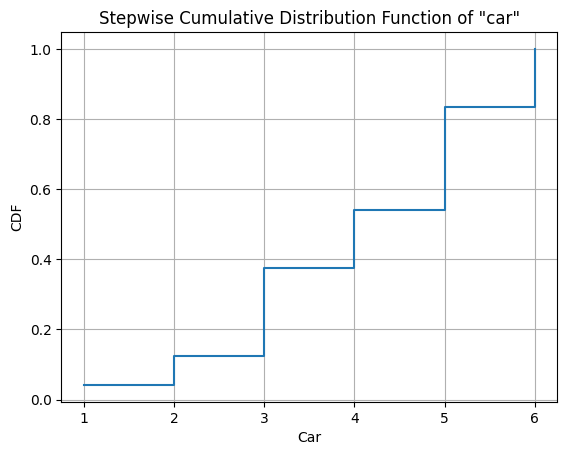

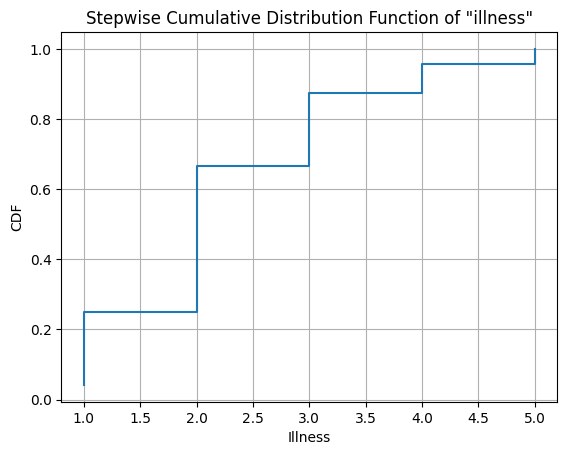

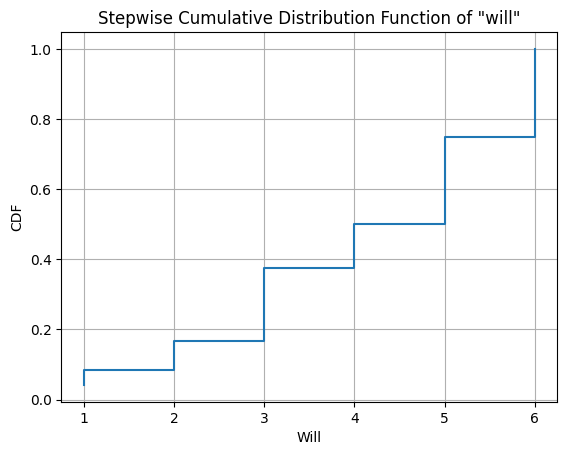

In [6]:
def plot_and_save_cdf(data, column_name, subfolder_name, by_treatment=True):
    # Create a figure and axis
    fig, ax = plt.subplots()

    if by_treatment:
        # Group the DataFrame by the "treatment" column
        grouped_data = data.groupby('valence')[column_name]

        # Calculate and plot the stepwise CDF for each treatment group
        for treatment, group in grouped_data:
            sorted_data = np.sort(group)
            cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
            ax.step(sorted_data, cdf, where='post', label=treatment)

        # Add legend
        ax.legend()

    else:
        # Calculate and plot the stepwise CDF for the entire dataset
        sorted_data = np.sort(data[column_name])
        cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
        ax.step(sorted_data, cdf, where='post')

    # Add labels and title
    ax.set_xlabel(column_name.capitalize())
    ax.set_ylabel('CDF')
    ax.set_title(f'Stepwise Cumulative Distribution Function of "{column_name}"')

    # Show the plot
    ax.grid(True)

    # Create the Data directory if it doesn't exist
    if not os.path.exists('Output'):
        os.mkdir('Output')

    # Create the subfolder if it doesn't exist
    subfolder_path = os.path.join('Output', subfolder_name)
    if not os.path.exists(subfolder_path):
        os.mkdir(subfolder_path)

    # Save the figure in the subfolder
    file_path = os.path.join(subfolder_path, f'stepwise_cdf_{column_name}.png')
    plt.savefig(file_path)

    # Display the plot (optional)
    plt.show()

def plot_and_save_boxplot(data, column_name, subfolder_name, by_treatment=True):
    # Create a figure and axis
    fig, ax = plt.subplots()

    if by_treatment:
        # Data for boxplot
        treatment_values = data['valence'].unique()
        data_to_plot = [data[data['valence'] == treatment][column_name] for treatment in treatment_values]

        # Create the boxplots
        ax.boxplot(data_to_plot, labels=treatment_values)

    else:
        # Data for boxplot
        data_to_plot = data[column_name]

        # Create the boxplot
        ax.boxplot(data_to_plot)

    # Add labels and title
    ax.set_ylabel(column_name.capitalize())
    ax.set_title(f'Boxplot of "{column_name}"')

    # Show the plot
    ax.grid(True)

    # Create the Data directory if it doesn't exist
    if not os.path.exists('Output'):
        os.mkdir('Output')

    # Create the subfolder if it doesn't exist
    subfolder_path = os.path.join('Output', subfolder_name)
    if not os.path.exists(subfolder_path):
        os.mkdir(subfolder_path)

    # Save the boxplot in the subfolder
    file_path = os.path.join(subfolder_path, f'boxplot_{column_name}.png')
    plt.savefig(file_path)

    # Display the plot (optional)
    plt.show()

# Call the function to plot and save the CDF for 'emotionsPart1'
plot_and_save_cdf(data, 'emotionsPart1', subfolder_name)


# Call the function to plot and save the CDF for 'num_draws'
plot_and_save_cdf(data, 'num_draws', subfolder_name)

# Call the function to plot and save the CDF for 'payoff'
plot_and_save_cdf(data, 'payoff', subfolder_name)

# Call the function to plot and save the CDF for 'mistakes_total'
plot_and_save_cdf(data, 'mistakes_total', subfolder_name)

# Call the function to plot and save the boxplot for 'num_draws'
plot_and_save_boxplot(data, 'num_draws', subfolder_name)

# Call the function to plot and save the boxplot for 'payoff'
plot_and_save_boxplot(data, 'payoff', subfolder_name)

# Call the function to plot and save the boxplot for 'mistakes_total'
plot_and_save_boxplot(data, 'mistakes_total', subfolder_name)


# Call the function to plot and save the CDF for 'wtp_point'
plot_and_save_cdf(data, 'wtp_point', subfolder_name)


# Call the function to plot and save the boxplot for 'wtp_point'
plot_and_save_boxplot(data, 'wtp_point', subfolder_name)


# Call the function to plot and save the CDF for 'study_duration'
plot_and_save_cdf(data, 'study_duration_minutes', subfolder_name, by_treatment=False)


# Call the function to plot and save the CDF for 'study_duration'
plot_and_save_cdf(data, 'study_duration_minutes', subfolder_name)


# Call the function to plot and save the boxplot for 'study_duration'
plot_and_save_boxplot(data, 'study_duration_minutes', subfolder_name, by_treatment=False)


# Call the function to plot and save the CDF for 'confused_binary'
plot_and_save_cdf(data, 'confused_binary', subfolder_name, by_treatment=False)


# Call the function to plot and save the boxplot for 'confused_binary'
plot_and_save_boxplot(data, 'confused_binary', subfolder_name, by_treatment=False)


for question in all_questions:
    # Call the function to plot and save the CDF for question
    plot_and_save_cdf(data, question, subfolder_name, by_treatment=False)

    # Call the function to plot and save the boxplot for question
    plot_and_save_boxplot(data, question, subfolder_name, by_treatment=False)


unincentivized_questions = ['summary_bad','summary_good'] + ['vacation','lottery','date','portfolio'] + ['sports','car', 'illness','will']

for question in unincentivized_questions:
    # Call the function to plot and save the CDF for question
    plot_and_save_cdf(data, question, subfolder_name, by_treatment=False)


In [7]:
data['wtp_point']

0      2.75
1      3.75
2      7.00
3     -5.00
4      3.75
5      5.25
6      4.25
7      9.00
8       NaN
9     -5.00
10     5.25
11     5.25
12      NaN
13     4.25
14     3.75
16     2.75
17     2.25
18     3.75
19     7.00
20     4.25
21    15.00
22     9.00
23     7.00
24     7.00
Name: wtp_point, dtype: float64

In [8]:
data['actual_data'][0]

{'num_draws': 18,
 'open_page': 'page1',
 'tentative_bonus': '3.25',
 'tentative_bonus_sequence': [2,
  '2.51',
  '2.51',
  '2.51',
  '2.51',
  '2.89',
  '3.13',
  '3.13',
  '3.13',
  '3.13',
  '3.13',
  '3.13',
  '3.13',
  '3.13',
  '3.13',
  '3.13',
  '3.13',
  '3.25']}

In [9]:
data['summary'] = data['summary_bad'] + data['summary_good']

median = data['summary'].median()

data[data['summary']<=median-1].groupby('valence')['wtp_point'].mean()  


valence
bonus      5.583333
penalty    7.125000
Name: wtp_point, dtype: float64

In [12]:
print(data[data['max_bonus_possible']==True].groupby('valence')['num_draws'].median())


valence
bonus      14.0
penalty    21.0
Name: num_draws, dtype: float64
